# Propellant Storage

In [1]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using JSON
PyPlot.matplotlib.style.use("Solarize_Light2")

The temperature is 298 K in the atmosphere.

In [2]:
const T = 298.0 # K

298.0

Universal gas constant

In [3]:
const R = 8.3144598e-5 # m³-bar/(K-mol)

8.3144598e-5

Mass desired of xenon propellant. [Source](https://doi.org/10.2514/6.2000-3677) for typical amount of Xe to bring into space: 89 kg

In [4]:
const N = 1000 # mol

1000

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:151
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\EOS.jl:151


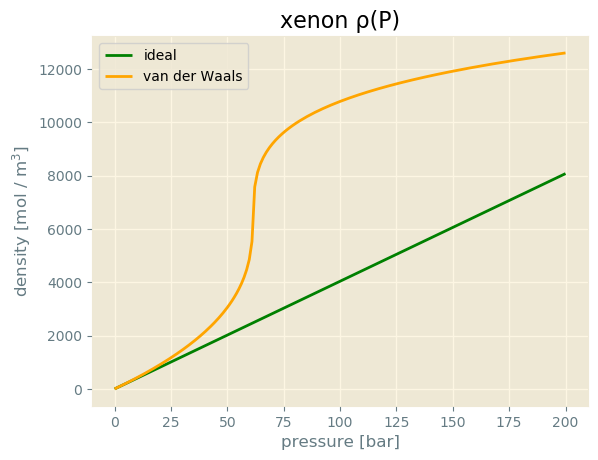

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:154
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\EOS.jl:154
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:155
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\EOS.jl:155


In [5]:
P = 10 .^ range(-2.0, stop=log10(200.), length=501)#[2:end] # bar

# ideal gas density
ρ_ig = P / (R * T) # mol / m³

ρ_vdw = zeros(length(P))
xe = VdWFluid(:Xe)

for (i, p_i) in enumerate(P)
    props = calculate_properties(xe, T, p_i, verbose=false)
    ρ_vdw[i] = props["density (mol/m³)"]
end
    
figure()
plot(P, ρ_ig, color="green", label="ideal")
plot(P, ρ_vdw, color="orange", label="van der Waals")
xlabel("pressure [bar]")
ylabel("density [mol / m\$^3\$]")
legend()
title("xenon ρ(P)")
savefig("Xenon Ideal Gas vs. van der Waals Gas Density.pdf", format="pdf")

For a thin-walled containing a supercritical, pressurized fluid without considering safety factor $\beta$

Assume the tank is made of Kevlar 49 [[Source](http://www.mse.mtu.edu/~drjohn/my4150/props.html)].

In [6]:
const ρ_tank_material = 1470.0 # kg/m³
const σ = 28000.0 # yield strength of Kevlar 49 (bar)

28000.0

Volume of the tank must be equal to the volume of propellant (of course). This allows us to, given a propellant storage density $\rho_p$, compute the radius of the spherical tank needed.

$4/3 \pi  r ^ 3 = m_p / \rho_{vdw}$

In [7]:
r = (N * 3 ./ (4 * π * ρ_vdw)) .^ (1 / 3); # inner radius of tank (m)

Minimum wall thickness required to contain the pressure of supercritical fluid. Thickness is found using the free-body diagram of a spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength and thickness of the wall ($2 \pi  r \sigma  t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
2 \pi  r \sigma  t=P \pi  r ^ 2
\end{equation}

In [8]:
t_tank_wall = P .* r / (2 * σ); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [9]:
m_tank = ρ_tank_material * 4 * π .* r .^ 2 .* t_tank_wall; # kg

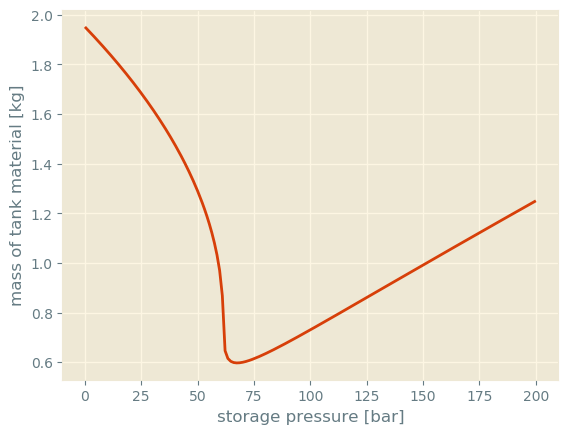

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [10]:
figure()
plot(P, m_tank, color=(215/255, 63/255, 9/255))
xlabel("storage pressure [bar]")
ylabel("mass of tank material [kg]")
#legend()
# title("Xenon in Kevlar 49")
show()
#savefig("Xenon van der Waals Gas in Pure Kevlar 49.pdf", format="pdf")

NOTE: this is using PURE Kevlar 49. Titanium is typically used only as an inner lining with carbon fiber overwrapping* -- [Source](https://doi.org/10.2514/6.2000-3677)
Kevlar 49 is used as 80-90% of the structural integrity of the tank while the lining makes direct contact with the compressed fluid. The lining does provide structural support, but very little compared to the overwrap.

Percent mass is used to measure the adsorption of an isotherm to a MOF in many research studies. Percent mass represents the ratio of the mass of fluid adsorbed to the sum of the mass of MOF and the mass of fluid adsorbed. 
\begin{equation} 
Percent mass = m_{fluid}/ (m_{mof}+m_{fluid})
\end{equation} 
We converted percent mass to the adsorption units of mol/L by dividing the percentage of the ratio by 100 to get the value of the ratio, then multiplying it by 1 mole of the propellant divided by the molar mass of the propellant in grams, then multiplying by 1000 to convert from mol/g to mol/kg, and finally multiplying by the density of the mof crystal in kg/L. 
\begin{equation}
adsorption(mol/L) = m_{fluid}/(m_{mof}+m_{fluid}) * 1/100 * 1 mol_{xe}/131.293 g_{xe} * 1000 g/1 kg * \rho_{mof}
\end{equation}
Density of gas in MOF $(mol_{gas} / L)$ is equal to the adsorption calculated from the above conversion.

In [11]:
global PATH_TO_DATA = joinpath(pwd(), "data")

function isotherm_data(isotherm_filename::AbstractString)
    file = open(joinpath(PATH_TO_DATA, "isotherms", isotherm_filename))
    lines = readlines(file)
    close(file)
    data = JSON.parse(join(lines))
    
    pressure_pts = Array{Float64,1}()
    adsorption_pts = Array{Float64,1}()

    for datapoints_dict in data["isotherm_data"]
        append!(pressure_pts, datapoints_dict["pressure"])
        append!(adsorption_pts, datapoints_dict["total_adsorption"])
    end

    df_isotherm = Dict{Symbol, Array{Float64}}()
        df_isotherm[Symbol("P(bar)")] = pressure_pts
        df_isotherm[Symbol("Adsorption(mmol/g)")] = adsorption_pts
    DataFrame(df_isotherm)
end

isotherm_data (generic function with 1 method)

In [32]:
df = isotherm_data("10.1016j.micromeso.2012.11.013.isotherm1.json")

,Adsorption(mmol/g),P(bar)
,Float64,Float64
1,0.194152,0.15166
2,0.46874,0.308976
3,1.2925,0.709416
4,2.11626,1.23857
5,2.94861,1.79632
6,3.37765,2.15386
7,3.67798,2.61151
8,4.01263,3.12636
9,4.61329,4.05595


In [33]:
const ρ_mof = 0.555 # kg/L

df[!, :mol_L] = df[!, Symbol("Adsorption(mmol/g)")] * ρ_mof
showall(df)

15×3 DataFrame
│ Row │ Adsorption(mmol/g) │ P(bar)   │ mol_L    │
│     │ Float64            │ Float64  │ Float64  │
├─────┼────────────────────┼──────────┼──────────┤
│ 1   │ 0.194152           │ 0.15166  │ 0.107754 │
│ 2   │ 0.46874            │ 0.308976 │ 0.260151 │
│ 3   │ 1.2925             │ 0.709416 │ 0.717338 │
│ 4   │ 2.11626            │ 1.23857  │ 1.17452  │
│ 5   │ 2.94861            │ 1.79632  │ 1.63648  │
│ 6   │ 3.37765            │ 2.15386  │ 1.8746   │
│ 7   │ 3.67798            │ 2.61151  │ 2.04128  │
│ 8   │ 4.01263            │ 3.12636  │ 2.22701  │
│ 9   │ 4.61329            │ 4.05595  │ 2.56038  │
│ 10  │ 4.89646            │ 5.01415  │ 2.71754  │
│ 11  │ 5.16247            │ 5.98664  │ 2.86517  │
│ 12  │ 5.29976            │ 6.95914  │ 2.94137  │
│ 13  │ 5.44564            │ 7.88873  │ 3.02233  │
│ 14  │ 5.53145            │ 8.87553  │ 3.06995  │
│ 15  │ 5.62584            │ 9.91954  │ 3.12234  │

In [14]:
#PATH_TO_DATA = joinpath(pwd(), "data")
#df_SBMOF1 = CSV.read(joinpath(PATH_TO_DATA, "isotherms", "SBMOF-1_298K.csv"))

In [15]:
#frame = Framework("SBMOF-1_cory.cif")
#strip_numbers_from_atom_labels!(frame)
#const ρ_mof_SB = crystal_density(frame) / 1000 # kg/L

#df_SBMOF1[!, :mol_L] = df_SBMOF1[!, :PercentMass] / 100.0 / read_atomic_masses()[:Xe] * 1000 * ρ_mof # mol gas / L  
#df_SBMOF1[!, :bar] = df_SBMOF1[!, Symbol("P(mbar)")] / 1000 # bar
#df_SBMOF1

Using the function "fit_adsorption_isotherm" from Porous Materials, we calculated M, the density of gas in the mof at saturation in mol/L, and the langmuir proportionality constant K. The function also extrapolated from the data and created a Langmuir model which is equal to M multiplied by K and Pressure P divided by 1 plus K multiplied by P.
\begin{equation}
L = M KP/(1+KP)
\end{equation} 
The Langmuir model was then fitted to the experimental data and the root mean square was calculated, showing how good of a fit the model is to the experimental data. 

In [16]:
params = fit_adsorption_isotherm(copy(df), Symbol("P(bar)"), Symbol("mol_L"), :langmuir)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = fit_adsorption_isotherm(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:193
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\Misc.jl:193
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = fit_adsorption_isotherm(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:194
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\Misc.jl:194
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = _guess(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:143
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\Misc.jl:143
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = _guess(::DataFrame, ::Symbol, ::Symb

Dict{String,Float64} with 3 entries:
  "M"   => 4.1096
  "K"   => 0.363142
  "MSE" => 0.00685528

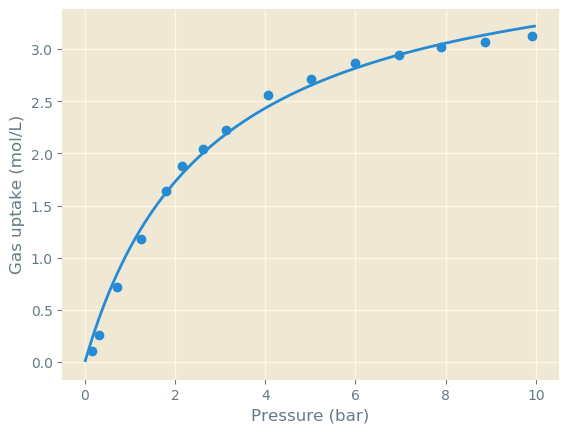

PyObject Text(25.000000000000014, 0.5, 'Gas uptake (mol/L)')

In [17]:
P_fit = range(0.0, stop=10.0, length=100)
N_fit = params["M"] * params["K"] .* P_fit ./ (1 .+ params["K"] .* P_fit)
fig = figure()
scatter(df[!, Symbol("P(bar)")], df[!, Symbol("mol_L")])
plot(P_fit, N_fit)
xlabel("Pressure (bar)")
ylabel("Gas uptake (mol/L)")

In [18]:
function ρ_fluid_MOF(P::Array{Float64}, K::Float64, M::Float64) 
    df_mof = Dict{Symbol, Array{Float64}}()
    df_mof[Symbol("P(bar)")] = P
    df_mof[Symbol("Density of Xe in MOF (mol/L)")] = (M * (K .* P)) ./ (1 .+ K .* P)
    return df_mof
end

ρ_fluid_MOF (generic function with 1 method)

In [19]:
df_mof = ρ_fluid_MOF(collect(P), params["K"], params["M"])
df_Xe_density = DataFrame(df_mof)
#CSV.write(df_Xe_density, "Xe_densities_langmuir.csv")

,Density of Xe in MOF (mol/L),P(bar)
,Float64,Float64
1,0.0148697,0.01
2,0.0151661,0.0102
3,0.0154683,0.0104041
4,0.0157766,0.0106122
5,0.0160909,0.0108245
6,0.0164115,0.011041
7,0.0167385,0.0112619
8,0.017072,0.0114872
9,0.017412,0.011717


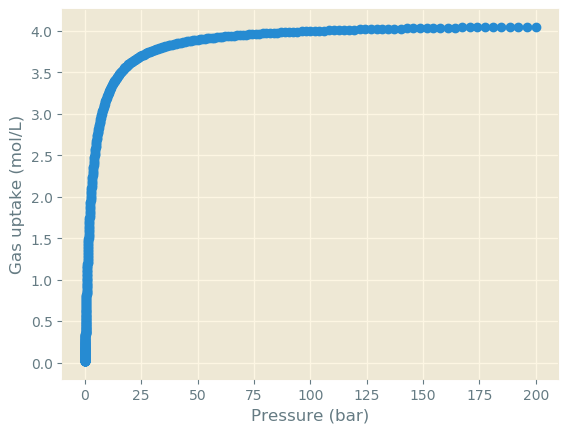

PyObject Text(25.000000000000014, 0.5, 'Gas uptake (mol/L)')

In [20]:
fig = figure()
scatter(P[2:end], df_Xe_density[!, Symbol("Density of Xe in MOF (mol/L)")][2:end])
xlabel("Pressure (bar)")
ylabel("Gas uptake (mol/L)")

Mass of MOF needed to carry desired amount of gas. 
\begin{equation}
m_{mof} = N \rho _{xtal}  / \rho _{fluid}
\end{equation}

In [21]:
m_of_mof = (N * ρ_mof) ./ df_Xe_density[!, Symbol("Density of Xe in MOF (mol/L)")]; # kg

The volume of the tank storing the mof is equal to the volume of the mof required to store the desired amount of propellant.
\begin{equation}
V_{tank with mof} = m_{mof} / \rho_{mof} = 4/3 \pi r_{tank}^3
\end{equation}


In [22]:
V_tank_with_mof = m_of_mof ./ ρ_mof ;

The volume of the tank is equal to the volume of the mof. Therefore using the volume of the mof, we can solve for the radius of the tank storing the mof. 
\begin{equation}
r_{tank with mof} = (3 m_{mof} / 4 \pi \rho_{mof})^{1/3}
\end{equation}

In [23]:
r_tank_with_mof = (m_of_mof * 3 ./ (4 * π * ρ_mof)) .^ (1 / 3); # inner radius of tank (m) # inner radius of tank with mof(m)

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P r_{tank with mof} / 2\sigma
\end{equation} 


In [24]:
t_tank_with_mof = P .* r_tank_with_mof / (2 * σ);

The total mass of the tank and mof for the desired amount of propellant is equal to the mass of the mof required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the mof. 


In [25]:
m_tank_with_mof = m_of_mof .+ 4 * π .* r_tank_with_mof .^ 2 .* t_tank_with_mof * ρ_tank_material;

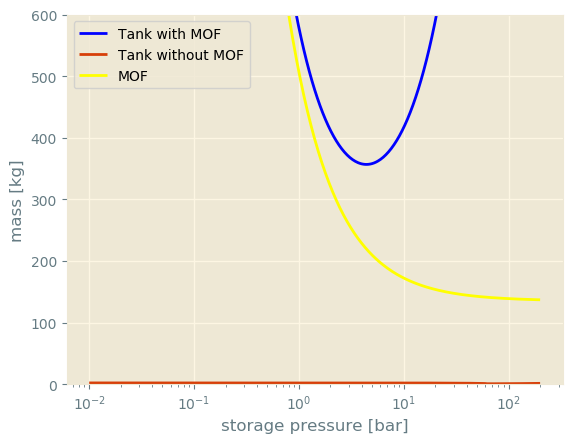

In [26]:
figure()
plot(P, m_tank_with_mof, color="blue", label="Tank with MOF")
plot(P, m_tank, color=(215/255, 63/255, 9/255), label="Tank without MOF")
plot(P, m_of_mof, color="yellow", label="MOF")
xlabel("storage pressure [bar]")
ylabel("mass [kg]")
ax = gca()
ax.set_xscale("log")
ylim(0, 600)
legend()
display()

In [27]:
minimum_mass_index = argmin(m_tank_with_mof)

308

In [28]:
df_minimum = Dict("Min pressure (bar)" => P[minimum_mass_index], 
                    "Min radius (m)" => r_tank_with_mof[minimum_mass_index],
                    "Min thickness (m)" => t_tank_with_mof[minimum_mass_index], 
                    "Min volume (L)" => V_tank_with_mof[minimum_mass_index],
                    "Min mass of mof (kg)" => m_of_mof[minimum_mass_index],
                    "Min mass of tank with mof (kg)" => m_tank_with_mof[minimum_mass_index])
df_minimum

Dict{String,Float64} with 6 entries:
  "Min volume (L)"                 => 396.544
  "Min thickness (m)"              => 0.000355941
  "Min pressure (bar)"             => 4.37353
  "Min radius (m)"                 => 4.55758
  "Min mass of tank with mof (kg)" => 356.658
  "Min mass of mof (kg)"           => 220.082

Optimum may come from saturation point of material.
It seems that the MOF used to store the desired amount of propellant saturate very early on. The pressure range we test at is far to great compared to the isotherm data (which typically range from 0-10bar).
